In [93]:
import scipy as sp
from scipy import integrate
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [13]:
r  = robjects.r
cf = robjects.FloatVector

In [3]:
libPaths=r[".libPaths"]

In [4]:
libPaths(robjects.StrVector([libPaths()[0], libPaths()[1], "D:/Documents/R/win-library/3.3"]))

R object with classes: ('character',) mapped to:
<StrVector - Python:0x0000023C5608DAC8 / R:0x0000023C5567F378>
['C:/Program Fi..., 'C:/Program Fi..., 'D:/Documents/...]

In [5]:
importr("stabledist")

rpy2.robjects.packages.Package as a <module 'stabledist'>

In [213]:
levy     = r["dstable"]
quantile = r["qstable"]

In [61]:
def PlotLevy(alphas, gammas, res=100, rng=[0.05, 0.95]):
    if type(alphas)==float or type(alphas)==int:
        alphas = [alphas]
    if type(gammas)==float or type(gammas)==int:
        gammas = [gammas]
    for alpha in alphas:
        for gamma in gammas:
            x = np.linspace( quantile(rng[0], alpha=alpha, gamma=gamma, beta=0)[0],
                             quantile(rng[1], alpha=alpha, gamma=gamma, beta=0)[0], res)
            y = np.array(levy(cf(x), alpha=alpha, gamma=gamma, beta=0))
            plt.figure(0, (14,7))
            plt.xlabel("x", fontsize=18)
            plt.ylabel("P(x)", fontsize=18)
            plt.plot(x,y, label=r"$\alpha=%.2f\;\; R=%.2f$"%(alpha, gamma))
    plt.legend(fontsize=18)

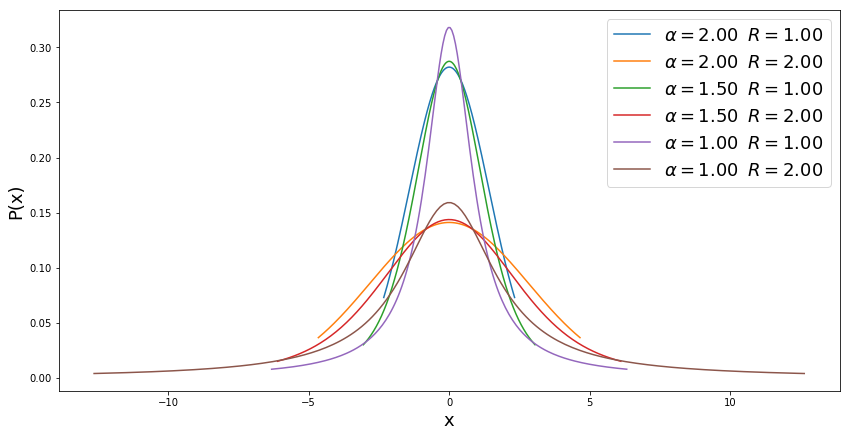

In [214]:
PlotLevy([2, 1.5, 1], [1,2], res=200)

\begin{equation}
\mathcal{L}(\boldsymbol{r}, \alpha, R) = \frac{1}{(2\pi)^3}\int d^3 \boldsymbol {q} e^{i\boldsymbol {q}\boldsymbol {r}}e^{-\frac{1}{2}|\boldsymbol {q}R|^\alpha}
\end{equation}

## 1D

In [439]:
def mcmc_1d(num_samples, f, fpars, pi, ppars, proposal_sigma=1.0):
    xi = np.random.uniform()
    s  = f(xi, *fpars)-f(xi, *fpars)
    for i in range(num_samples):
        xg = np.random.normal(xi, proposal_sigma)
        if np.random.uniform()<pi(xg, *ppars)/pi(xi, *ppars):
            xi = xg
        s += f(xi, *fpars)
    return s/float(num_samples)

In [347]:
def f(x, r, alpha, R):
    return np.exp(1j*np.dot(x,r))

def p(x, alpha, R):
    return np.exp(-np.power(np.linalg.norm(x)*R, alpha) )

def Levy1D_MCMC(r, alpha, R, num_samples):
    C = integrate.quad(p, -np.inf, np.inf, args=(alpha, R))[0]
    return C*mcmc_1d(num_samples, f, (r, alpha, R), p, (alpha, R))/(2*np.pi)

def Levy_int(r, alpha, R):
    return integrate.quad(lambda x: f(x, r, alpha,R).real*p(x,alpha,R), -np.inf, np.inf)[0]/(2*np.pi)

In [358]:
x = np.linspace(-10,10,20)
y = [Levy1D_MCMC(q, 0.7, 3, 3000) for q in x]

In [359]:
x1 = np.linspace(-10,10,20)
y1 = [Levy_int(q, 0.7, 3) for q in x]

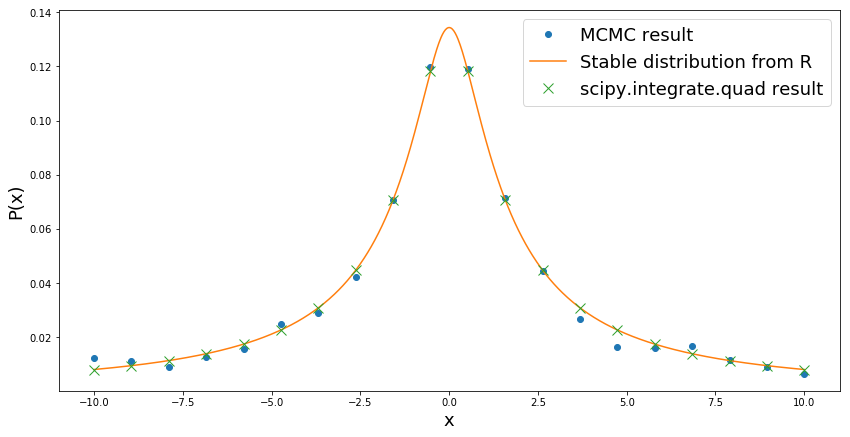

In [368]:
plt.figure(0,(14,7))
plt.xlabel("x", fontsize=18)
plt.ylabel("P(x)", fontsize=18)
plt.plot(x,np.real(np.array(y)), 'o', label="MCMC result")
x2 = np.linspace(-10,10,1000)
y2 = np.array(levy(cf(x2), alpha=0.7, gamma=3, beta=0))
plt.plot(x2,y2, label="Stable distribution from R")
plt.plot(x1,y1, 'x', markersize=10, label="scipy.integrate.quad result")
plt.legend(fontsize=18)

## 3D

In [481]:
def f(x, r, alpha, R):
    return np.exp(1j*np.dot(x,r))*x**2

def Levy3D_MCMC(r, alpha, R, num_samples):
    C = integrate.quad(p, -np.inf, np.inf, args=(alpha, R))[0]
    return 4*np.pi*C*mcmc_1d(num_samples, f, (r, alpha, R), p, (alpha, R))/(2*np.pi)**3  / 2

In [483]:
def fe(x, r, alpha, R):
    return 4*np.pi*x**2*np.exp(-np.power(np.linalg.norm(x)*R, alpha))*np.exp(-1j*np.linalg.norm(x)*r).real/(2*np.pi)**3

In [500]:
x = np.linspace(-10,10,40)
y = [Levy3D_MCMC(q, 0.7, 3, 5000) for q in x]

In [497]:
x1 = np.linspace(-10,10,300)
y1 = np.array([integrate.quad(fe, 0, np.inf, args=(q, 0.7, 3))[0] for q in x1])

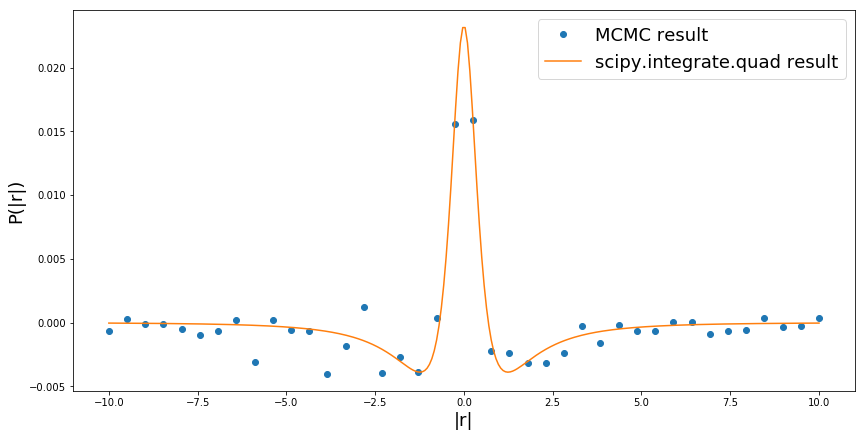

In [501]:
plt.figure(0,(14,7))
plt.xlabel("|r|", fontsize=18)
plt.ylabel("P(|r|)", fontsize=18)
plt.plot(x,np.real(np.array(y)), 'o', label="MCMC result")
plt.plot(x1,y1, label="scipy.integrate.quad result")
plt.legend(fontsize=18)